1/1 [==============================] - 0s 26ms/step


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46973 (\N{HANGUL SYLLABLE RAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


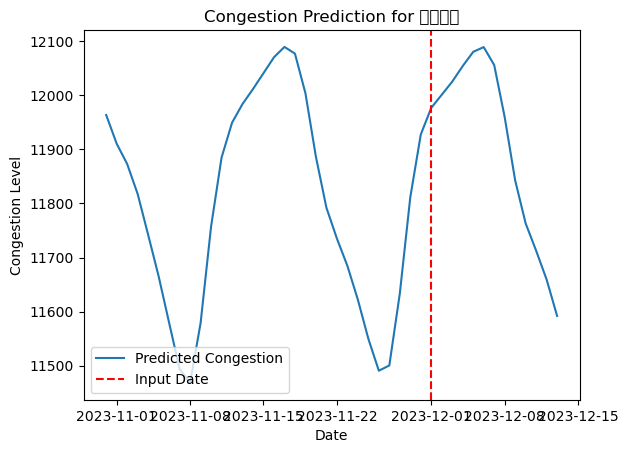

날짜 차: 31
날짜: 2023-12-01, 입력 시간: 18:30, 예측 인원: 11592.0908203125, 혼잡도: 109.19


In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import model_from_json
import numpy as np

def map_time_to_number(time_str):
    time_obj = datetime.strptime(time_str, '%H:%M')
    hour = time_obj.hour
    minute = time_obj.minute

    if 4 <= hour < 6:
        return 1
    elif 6 <= hour < 7:
        return 2
    elif 7 <= hour < 8:
        return 3
    elif 8 <= hour < 9:
        return 4
    elif 9 <= hour < 10:
        return 5
    elif 10 <= hour < 11:
        return 6
    elif 11 <= hour < 12:
        return 7
    elif 12 <= hour < 13:
        return 8
    elif 13 <= hour < 14:
        return 9
    elif 14 <= hour < 15:
        return 10
    elif 15 <= hour < 16:
        return 11
    elif 16 <= hour < 17:
        return 12
    elif 17 <= hour < 18:
        return 13
    elif 18 <= hour < 19:
        return 14
    elif 19 <= hour < 20:
        return 15
    elif 20 <= hour < 21:
        return 16
    elif 21 <= hour < 22:
        return 17
    elif 22 <= hour < 23:
        return 18
    elif 23 <= hour or hour < 2:
        return 19
    else:
        return 0  # 예외 처리 - 해당되지 않는 경우

# 역명과 모델 파일명
station_name = '가락시장'
model_json_file = 'model2.json'
model_weights_file = 'model2_weights.h5'
data_file = f'{station_name}2.csv'

# 모델 로드
json_file = open(model_json_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(model_weights_file)

# 데이터 불러오기
data = pd.read_csv(data_file, header=None)
data = data.values.astype('float32')
data = data.reshape(len(data), 1)

# 0부터 1로 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# 입력 데이터 생성
look_back = 10  # 예측에 사용할 이전 데이터 수
input_data = data[-look_back:]
input_data = np.reshape(input_data, (1, look_back, 1))

# 입력 날짜와 마지막 날짜 간격 계산
input_date = datetime.strptime('2023-12-01', '%Y-%m-%d')  # 입력 날짜
prediction_date = datetime.strptime('2023-10-31', '%Y-%m-%d')  # 데이터의 마지막 날짜

date_diff = (input_date - prediction_date).days

# 시간
input_time = '18:30'
mapped_time = map_time_to_number(input_time)

# 예측
predictions = []
for i in range((date_diff-1) + mapped_time): 
    predicted_value = model.predict(input_data)
    predictions.append(predicted_value[0, 0])
    input_data = np.append(input_data[:, 1:, :], [[[predicted_value[0, 0]]]], axis=1)

# 스케일링 역변환
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions)

# 그래프 플로팅
dates = [prediction_date + timedelta(days=i) for i in range((date_diff-1) + mapped_time)]
plt.plot(dates, predictions, label='Predicted Congestion')

# 예측 날짜를 강조하는 수직선 추가
plt.axvline(x=input_date, color='r', linestyle='--', label='Input Date')

plt.title(f'Congestion Prediction for {station_name}')
plt.xlabel('Date')
plt.ylabel('Congestion Level')
plt.legend()
plt.show()

# 마지막 예측 결과 및 혼잡도 출력
last_prediction = predictions[-1]
congestion = round((last_prediction[0] / 26541) * 250, 2)
print(f'날짜 차: {date_diff}')
print(f'날짜: {input_date.date()}, 입력 시간: {input_time}, 예측 인원: {last_prediction[0]}, 혼잡도: {congestion}')